In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.utils.dynamical_systems import Lorenz63
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.esn import ESN
from functools import partial
from adjoint_esn.utils.discretizations import finite_differences

In [2]:
sys = Lorenz63
params = {'beta':8/3,'rho':28,'sigma':10}
sim_time = 100
sim_dt = 1e-2
random_seed = 0
integrator = 'rk4'
network_dt = 1e-2
transient_time = 20
washout_time = 4
input_vars = ['x','y','z']
param_vars = []
loop_times = [5.0,1.0,1.0]
loop_names = ['train','val','test']
noise_level = 0

my_sys, y_sim, t_sim = pp.load_data_dyn_sys(sys,
                                            params,
                                            sim_time,
                                            sim_dt,
                                            random_seed=random_seed,
                                            integrator=integrator)
# Lyapunov_Time(sys, params)
data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    input_vars=input_vars,
                    param_vars=param_vars,
                    loop_times=loop_times,
                    loop_names=loop_names,
                    noise_level=noise_level,
                    random_seed=random_seed)

dim = data["train"]["u"].shape[1]

In [3]:
ESN_dict = {
        "reservoir_size": 300,
        "parameter_dimension": 0,
        "reservoir_connectivity": 3,
        "r2_mode": False,
        "input_only_mode": False,
        "input_weights_mode": 'sparse_grouped',
        "reservoir_weights_mode": 'erdos_renyi1',
        "tikhonov": 1e-6,
        "dimension": dim,
        "output_bias": np.array([]),
        "spectral_radius": 1.0,
        "input_scaling": 0.1,
    }

ESN_dict['input_seeds'] = [5,6,7]
ESN_dict['reservoir_seeds'] = [8,9]

my_ESN = ESN(**ESN_dict)
my_ESN.train(data["train"]["u_washout"], 
             data["train"]["u"], 
             data["train"]["y"],
            )

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


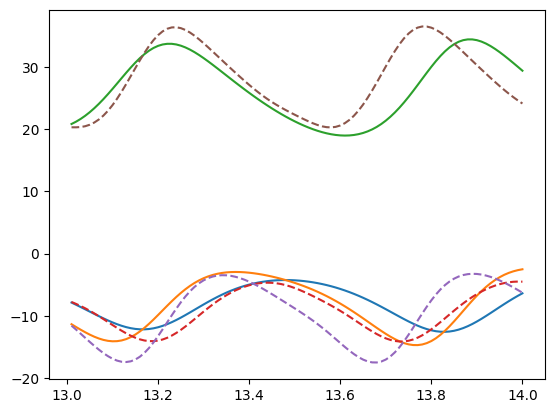

In [4]:
x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data['val']['u_washout'], 
                                            N_t=len(data['val']['u']))
# y_pred = y_pred[1:]

plt.plot(data['val']['t'],data['val']['y'])
plt.plot(data['val']['t'],y_pred[1:],'--')

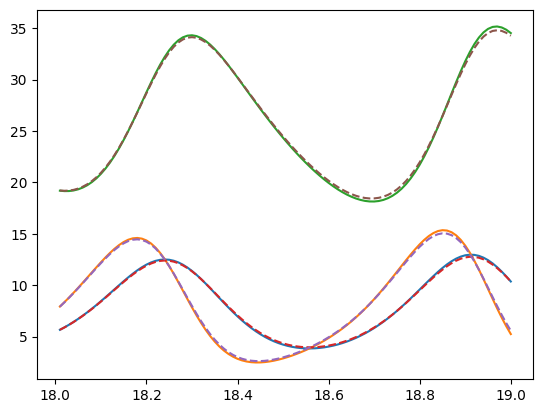

In [5]:
_, y_pred_test = my_ESN.closed_loop_with_washout(U_washout=data['test']["u_washout"], 
                                            N_t=len(data['test']["u"]))
# y_pred = y_pred[1:]

plt.plot(data['test']['t'],data['test']['y'])
plt.plot(data['test']['t'],y_pred_test[1:],'--')

In [6]:
def J_fun(Y, Y_true):
    return np.mean(np.linalg.norm(Y-Y_true, axis=1)**2)

def dJdy_fun(Y,Y_true):
    return 2 * (Y-Y_true)

def adjoint_sensitivity(my_ESN, X, Y, Y_true, N):
    """Sensitivity of the ESN with respect to the parameters
    Calculated using ADJOINT method
    Objective is squared L2 of the 2*N_g output states, i.e. acoustic energy

    Args:
        X: trajectory of reservoir states around which we find the sensitivity
        N: number of steps

    Returns:
        dJdWout: adjoint sensitivity to output weights
    """
    # reset grad attributes
    my_ESN.reset_grad_attrs()

    # if the objective is not defined the default is the acoustic energy
    # choose fast jacobian

    jac_fun = lambda dtanh, x_prev: my_ESN.fast_jac(dtanh)

    # initialize adjoint variables
    v = np.zeros((N + 1, my_ESN.N_reservoir))

    # initialize sensitivity
    dJdW_out = np.zeros(my_ESN.W_out.shape)

    # integrate backwards
    # predict galerkin amplitudes
    dJdy = dJdy_fun(Y[N], Y_true[N])

    # terminal condition,
    # i.e. gradient of the objective at the terminal state
    dydf = my_ESN.dydf(X[N, :])
    v[N] = (1 / N) * np.dot(dJdy, dydf).T

    try:
        my_W_in = my_ESN.W_in.toarray()
    except:
        my_W_in = my_ESN.W_in
        
    for i in np.arange(N, 0, -1):
        dtanh = my_ESN.dtanh(X[i, :], X[i - 1, :])[:, None]
        
        # partial derivative with respect to W_out
        W_in_x_i = np.einsum('ij,k->ijk', my_W_in, X[i-1,:])
        dfdW_out = my_ESN.alpha * np.einsum('i,ijk->ijk', dtanh.flatten(), W_in_x_i) # so far for W_out.T

        # sensitivity to W_out
        dJdW_out += np.einsum('i,ijk->kj', v[i], dfdW_out) # also transpose for W_out
        # MISSING partial J / partial W_out because W_out actually appears in the output too!!
        # REALLY CHECK ALL THESE CALCULATIONS
        dJdW_out += (1 / N) * np.einsum('i,j->ji', dJdy, X[i,:])

        # get the derivative of the objective with respect to the outputs
        dJdy = dJdy_fun(Y[i - 1], Y_true[i - 1])

        # gradient of objective with respect to reservoir states
        dydf = my_ESN.dydf(X[i - 1, :])
        dJdf = (1 / N) * np.dot(dJdy, dydf).T

        # jacobian of the reservoir dynamics
        jac = jac_fun(dtanh, X[i - 1, :])

        # integrate adjoint variables backwards in time
        v[i - 1] = np.dot(jac.T, v[i]) + dJdf

    return dJdW_out


def finite_difference_sensitivity(my_ESN, X, Y, Y_true, N, h = 1e-5):
    # initialize sensitivity
    dJdW_out = np.zeros(my_ESN.W_out.shape)

    # compute the energy of the base
    J = J_fun(Y[1:N+1, :],Y_true[1:N+1,:])

    # define which finite difference method to use
    finite_difference = partial(finite_differences, method='central')

    # perturbed by h
    W_out_orig = my_ESN.W_out
    for i in range(my_ESN.W_out_shape[0]):
        for j in range(my_ESN.W_out_shape[1]):
            W_out_left = W_out_orig.copy()
            W_out_left[i,j] -= h
            my_ESN.W_out = W_out_left
            _, Y_left = my_ESN.closed_loop(X[0, :], N)

            W_out_right = W_out_orig.copy()
            W_out_right[i,j] += h
            my_ESN.W_out = W_out_right

            _, Y_right = my_ESN.closed_loop(X[0, :], N)
            J_left = J_fun(Y_left[1:N+1, :],Y_true[1:N+1,:])
            J_right = J_fun(Y_right[1:N+1, :],Y_true[1:N+1,:])

            dJdW_out[i,j] = finite_difference(J, J_right, J_left, h)
    my_ESN.W_out = W_out_orig
    return dJdW_out

In [7]:
N = len(data['val']['u'])
x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data['val']['u_washout'], 
                                            N_t=N)
dJdW_out = adjoint_sensitivity(my_ESN, X=x_pred, Y=y_pred, Y_true=np.vstack((data['val']['u'][0],data['val']['y'])), 
                               N=N)
dJdW_out_finite = finite_difference_sensitivity(my_ESN, X=x_pred, Y=y_pred, Y_true=np.vstack((data['val']['u'][0],data['val']['y'])), 
                               N=N, h=1e-5)

In [34]:
W_out_orig = my_ESN.W_out
h = 1e-6
X = x_pred
dx_dW_out = np.zeros((my_ESN.N_reservoir,my_ESN.W_out_shape[0],my_ESN.W_out_shape[1]))
for i in range(my_ESN.W_out_shape[0]):
    for j in range(my_ESN.W_out_shape[1]):
        W_out_left = W_out_orig.copy()
        W_out_left[i,j] -= h
        my_ESN.W_out = W_out_left
        X_left, Y_left = my_ESN.closed_loop(X[0, :], 1)

        W_out_right = W_out_orig.copy()
        W_out_right[i,j] += h
        my_ESN.W_out = W_out_right

        X_right, Y_right = my_ESN.closed_loop(X[0, :], 1)

        for k in range(my_ESN.N_reservoir):
            dx_dW_out[k,i,j] = (X_right[-1,k]-X_left[-1,k])/(2*h)

Val error: 38.53836421057989
Test error: 0.07171847489865411
Val error: 35.141650629446914
Test error: 0.05772111611396554
Val error: 31.461362969645656
Test error: 0.04932729592586727
Val error: 27.475791974709036
Test error: 0.04759808192830342
Val error: 23.22056116461989
Test error: 0.05375373034762594
Val error: 18.86418878201953
Test error: 0.0688956834819674
Val error: 14.804223173141414
Test error: 0.09322758306632378
Val error: 11.64919382495039
Test error: 0.12459210531003209
Val error: 9.836725197374548
Test error: 0.1573069285885752
Val error: 9.125095746822804
Test error: 0.1844512607575198
Val error: 8.88021648081367
Test error: 0.2036472673500615
Val error: 8.737929426056125
Test error: 0.21777311575020522
Val error: 8.61062955321979
Test error: 0.2300107882560792
Val error: 8.486746223473014
Test error: 0.24184943512409884
Val error: 8.365141023333003
Test error: 0.2537824761674354
Val error: 8.245687599500076
Test error: 0.2659483523428312
Val error: 8.128345700398425


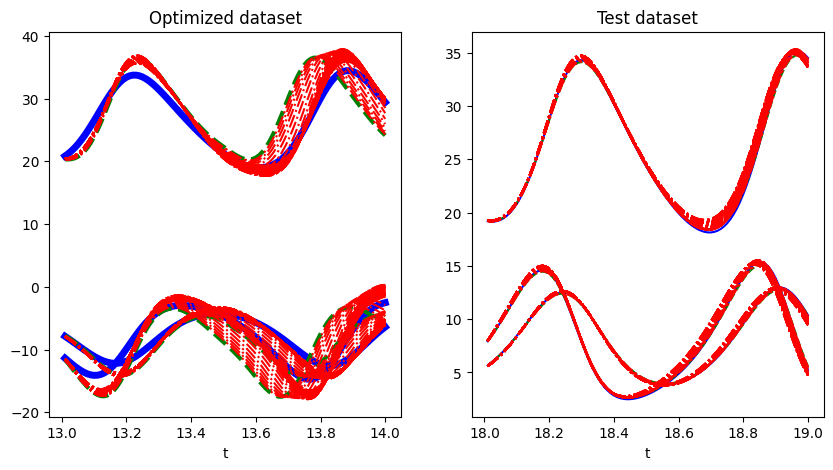

In [10]:
my_ESN.train(data["train"]["u_washout"], 
             data["train"]["u"], 
             data["train"]["y"],
            )
N = len(data['val']['u'])

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].set_title('Optimized dataset')
axs[0].set_xlabel('t')
axs[1].set_title('Test dataset')
axs[1].set_xlabel('t')

x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data['val']['u_washout'], 
                                            N_t=N)
print('Val error:',J_fun(Y=y_pred, Y_true=np.vstack((data['val']['u'][0],data['val']['y']))))
dJdW_out = adjoint_sensitivity(my_ESN, X=x_pred, Y=y_pred, Y_true=np.vstack((data['val']['u'][0],data['val']['y'])), 
                               N=N)

axs[0].plot(data['val']['t'],data['val']['y'],'b-', linewidth=5)
axs[0].plot(data['val']['t'],y_pred[1:],'g--', linewidth=3)
_, y_pred_test = my_ESN.closed_loop_with_washout(U_washout=data['test']['u_washout'], 
                                            N_t=len(data['test']['u']))
print('Test error:',J_fun(Y=y_pred_test, Y_true=np.vstack((data['test']['u'][0],data['test']['y']))))
axs[1].plot(data['test']['t'],data['test']['y'],'b-')
axs[1].plot(data['test']['t'],y_pred_test[1:],'g--')

lr = 1e-7
for i in range(100):
    my_ESN.W_out = my_ESN.W_out - lr * dJdW_out
    x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data['val']['u_washout'], 
                                                N_t=N)
    dJdW_out = adjoint_sensitivity(my_ESN, X=x_pred, Y=y_pred, Y_true=np.vstack((data['val']['u'][0],data['val']['y'])), 
                               N=N)

    axs[0].plot(data['val']['t'],y_pred[1:],'r-.')
    print('Val error:',J_fun(Y=y_pred, Y_true=np.vstack((data['val']['u'][0],data['val']['y']))))

    _, y_pred_test = my_ESN.closed_loop_with_washout(U_washout=data['test']['u_washout'], 
                                            N_t=len(data['test']['u']))
    print('Test error:',J_fun(Y=y_pred_test, Y_true=np.vstack((data['test']['u'][0],data['test']['y']))))
    axs[1].plot(data['test']['t'],y_pred_test[1:],'r-.')
